# **Goal 3**. 
# Mental Health Stigma Classification in OSMI & Kaggle Surveys (2014–2023)

This notebook performs a full pipeline for analyzing attitudes toward mental health in the tech industry across nine years of survey data (2014, 2016–2023). The workflow consists of:

1. **Loading and harmonizing datasets** from Kaggle (2014, 2016–2019) and OSMI (2020–2023).
2. **Extracting free-text answers** into a unified `"text"` column.
3. **Manual annotation** of ~200 examples (supportive vs. stigmatizing language).
4. **Semi-supervised labeling** of additional samples using Google Gemini.
5. **Training a RoBERTa-based classifier** on manually + LLM-labeled data.
6. **Evaluating** the model (accuracy, F1 score).
7. **Applying the classifier to all years (2014–2023)** to detect supportive/stigmatizing language.
8. **Trend analysis** to observe how attitudes change over time.

The goal is to quantify stigma patterns and shifts in mental-health discourse within the tech workforce.

## Install the needed libraries

#### To access the Gemini API from Python, we first install the official `google-genai` package.  
This lightweight client provides a simple interface for sending text
generation and classification requests to Google's Gemini models.

In [151]:
pip install google-genai

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


#### To fine-tune RoBERTa, we first need to install PyTorch, which provides the tensor backend and dataloader utilities used during training.

In [ ]:
pip install torch

#### Transformers need to be installed from HuggingFace

In [ ]:
pip install -U "transformers>=4.46.0" "huggingface_hub>=0.24.6"

#### HuggingFace `Trainer` relies on the **accelerate** library for efficient device management (CPU/GPU/MPS), mixed precision, and distributed training support. Even if training is done on CPU/MPS (MacBook Air), installing this package is recommended to avoid runtime warnings.

In [ ]:
pip install 'accelerate>=0.26.0'

## Combine all free-text fields into a single column
Combining all free-text responses into a single field allows a transformer model to capture the full semantic meaning of everything a respondent wrote, instead of treating each small text box separately. As a result, the model becomes more robust, more accurate, and better at recognizing subtle patterns related to mental health.

In [28]:
import numpy as np

In [39]:
def clean_val(v):
    bad_values = {"-1", ".", " ", "", "nan"}

    if pd.isna(v):
        return None
    v = str(v).strip()
    return None if v in bad_values else v
    

def free_text(df):
    df = df.replace("-1", np.nan)
    df = df.replace(-1, np.nan)

    exclude_free_text = {
    "#",
    "What country do you live in?",
    "What country do you work in?",
    "If you live in the United States, which state or territory do you live in?",
    "If yes, what condition(s) have you been diagnosed with?", # this would be data leakage
    "If maybe, what condition(s) do you believe you have?", # this also
    "What US state or territory do you work in?",
    "What is your age?",
    "What is your gender?",
    "SurveyID",
    "UserID",
    "Start Date (UTC)",
    "Submit Date (UTC)",
    "Network ID",
    }
    UNIQUE_THRESHOLD = 50       # columns with > 50 unique values are likely free text
    AVG_LENGTH_THRESHOLD = 20   # average length > 20 characters are likely free text

    # add all free text into one array
    free_text_cols = []
    for col in df.columns:
        if col in exclude_free_text:
            continue
            
        num_unique = df[col].nunique()
        avg_len = df[col].astype(str).apply(len).mean()
        if num_unique > UNIQUE_THRESHOLD or avg_len > AVG_LENGTH_THRESHOLD:
            free_text_cols.append(col)

    print("Dataset free-text columns are: ")
    for col in free_text_cols:
        print("-", col)
        
    # add all free text into one column & drop the others
    df["all_text"] = df[free_text_cols].apply(
        lambda row: " ".join(
            [clean_val(v) for v in row if clean_val(v) is not None]),
        axis=1)
    
    df["all_text"] = df["all_text"].replace("", np.nan)
    df.drop(columns=free_text_cols, inplace=True)

    return df

## Combine free-text (2023 version)
The 2023 dataset uses different schemas and column names. This function performs the same free-text merging logic while adapting to the updated structure.

In [40]:
def free_text_2023(df):
    df = df.replace("-1", np.nan)
    df = df.replace(-1, np.nan)

    free_text_cols = [
        "Describe the conversation you had with your employer about your mental health, including their reactions and what actions were taken to address your mental health issue/questions.",
        "Describe the conversation with coworkers you had about your mental health including their reactions.",
        "Describe the conversation your coworker had with you about their mental health (please do not use names).",
        "Describe the conversation you had with your previous employer about your mental health, including their reactions and actions taken to address your mental health issue/questions.",
        "Describe the conversation you had with your previous coworkers about your mental health including their reactions.",
        "Describe the conversation your coworker had with you about their mental health (please do not use names)..1",
        "Describe the circumstances of the supportive or well handled response.",
        "Describe the circumstances of the badly handled or unsupportive response.",
        "Briefly describe what you think the industry as a whole and/or employers could do to improve mental health support for employees.",
        "Would you have felt more comfortable talking to your previous employer about your physical health or your mental health?",
        "Were you aware of the options for mental health care provided by your previous employers?",
        "Would you have been willing to discuss your mental health with your direct supervisor(s)?",
        "Would you have been willing to discuss your mental health with your coworkers at previous employers?",
        "If there is anything else you would like to tell us that has not been covered by the survey questions, please use this space to do so.",
        "Why or why not?"
    ]
    
    df["all_text"] = df[free_text_cols].apply(
        lambda row: " ".join(
            [clean_val(v) for v in row if clean_val(v) is not None]),
        axis=1)
    
    df["all_text"] = df["all_text"].replace("", np.nan)
    df.drop(columns=free_text_cols, inplace=True)

    return df

### Extracting Free-Text Fields from the Kaggle Historical Dataset

The Kaggle dataset (2014–2019) contains over 100 columns, many of which are
multiple-choice or demographic variables. However, for the purpose of
language-based stigma classification we are only interested in **open-ended,
free-text responses**.

We therefore apply the `free_text()` function to automatically identify
columns likely to contain narrative answers. The detection is based on:

- high number of unique values,
- long average string length,
- exclusion of demographic or ID fields.

All detected free-text columns are concatenated into a single column:
`all_text`.

This unified field allows us to build a consistent text corpus across all
years.  

After processing, the Kaggle dataset retains the same number of rows
(4,218) but the number of columns decreases because all free-text responses
are merged, and non-text free-text columns are removed.

The preview shows that early survey years (2014–2015) contain no free-text
responses for the first few entries, which is expected due to limited
open-ended questions in early versions of the OSMI survey.

In [41]:
kaggle = pd.read_csv("../data/raw/kaggle_uncleaned.csv")
print("Kaggle shape before:", kaggle.shape)

kaggle = free_text(kaggle)

print("Kaggle shape after free_text:", kaggle.shape)
kaggle[["SurveyID", "all_text"]].head()
        

Kaggle shape before: (4218, 106)
Dataset free-text columns are: 
- Any additional notes or comments
- Briefly describe what you think the industry as a whole and/or employers could do to improve mental health support for employees.
- Describe the circumstances of the badly handled or unsupportive response.
- Describe the conversation with coworkers you had about your mental health including their reactions.
- Describe the conversation you had with your employer about your mental health, including their reactions and what actions were taken to address your mental health issue/questions.
- Describe the conversation you had with your previous coworkers about your mental health including their reactions.
- Describe the conversation you had with your previous employer about your mental health, including their reactions and actions taken to address your mental health issue/questions.
- Describe the conversation your coworker had with you about their mental health (please do not use names).
-

,SurveyID,all_text
0,2014,NaN
1,2014,NaN
2,2014,NaN
3,2014,NaN
4,2014,NaN


### Preparing Kaggle Free-Text Data for Labeling

After extracting free-text fields into the `all_text` column, we create a
standardized dataframe (`kaggle_text`) that matches the structure used for the
OSMI datasets and for model training.

Specifically:

- `SurveyID` is renamed to `year` because the Kaggle dataset encodes the
  survey year inside this column.
- `all_text` is renamed to `text` so that all datasets share a unified text
  field.
- A placeholder `label` column is added and filled with `NaN`, since the
  Kaggle historical dataset does not include stigma labels.
  These entries will later be ignored during model training unless we choose to
  generate pseudo-labels.

The resulting dataset contains:
- **4,218 rows**, matching the original Kaggle sample size.
- Columns: `year`, `text`, and `label`.

The first few rows show that many early-year responses contain no free text,
which is expected for the 2014–2015 survey versions that had fewer
open-ended questions.

In [42]:
kaggle_text = kaggle[["SurveyID", "all_text"]].rename(
    columns={"SurveyID": "year", "all_text": "text"}
)
kaggle_text["label"] = np.nan
print(kaggle_text.shape)
kaggle_text["year"].value_counts().sort_index()
kaggle_text.head()

(4218, 3)


,year,text,label
0,2014,NaN,NaN
1,2014,NaN,NaN
2,2014,NaN,NaN
3,2014,NaN,NaN
4,2014,NaN,NaN


### Processing OSMI Survey Data (2020–2023)

The OSMI mental-health surveys from 2020–2023 contain several open-ended
questions where respondents describe their experiences with mental health,
workplace attitudes, and conversations with employers or coworkers.

However, the survey structure **changes from year to year**, most notably in 2023,
which requires a separate text-extraction function.  
To standardize these datasets for later modeling, we perform the following steps
for each year:

1. **Load the raw CSV file** and display its original shape.
2. **Extract free-text answers**:
   - For 2023, call `free_text_2023()` because column names differ.
   - For 2020–2022, use the general `free_text()` function.
3. **Rename the combined text column** (`all_text`) to a unified field (`text`).
4. **Add metadata columns**:
   - `year` — the survey year
   - `label` — placeholder `NaN` values, because we will label these
     rows later using manual annotation or model-assisted labeling.
5. **Store the processed dataframe** in a list for later concatenation.

This loop produces a consistent text dataset across all OSMI survey years,
making the subsequent steps—merging, labeling, and training—the same for
every sample regardless of its original format.

Example rows are displayed for quick inspection to verify that free-text
aggregation worked correctly.

In [44]:
paths_osmi = {
    2020: "../data/raw/osmi_mental_health_2020.csv",
    2021: "../data/raw/osmi_mental_health_2021.csv",
    2022: "../data/raw/osmi_mental_health_2022.csv",
    2023: "../data/raw/osmi_mental_health_2023.csv",
}

osmi_text_dfs = []
for year, path in paths_osmi.items():
    print(f"\n=== Processing OSMI {year} ===")
    df = pd.read_csv(path)
    print("Raw shape:", df.shape)
    if year == 2023:
        df = free_text_2023(df)
    else:
        df = free_text(df)
    print("After free_text:", df.shape)

    tmp = df[["all_text"]].rename(columns={"all_text": "text"})
    tmp["year"] = year
    tmp["label"] = np.nan

    osmi_text_dfs.append(tmp)

    print(f"OSMI {year} example rows:")
    display(tmp.head(2))


=== Processing OSMI 2020 ===
Raw shape: (180, 120)
Dataset free-text columns are: 
- Describe the conversation you had with your employer about your mental health, including their reactions and what actions were taken to address your mental health issue/questions.
- Describe the conversation with coworkers you had about your mental health including their reactions.
- Describe the conversation your coworker had with you about their mental health (please do not use names).
- Would you have been willing to discuss your mental health with your direct supervisor(s)?
- Would you have been willing to discuss your mental health with your coworkers at previous employers?
- Describe the conversation you had with your previous coworkers about your mental health including their reactions.
- Why or why not?
- Why or why not?.1
- Describe the circumstances of the badly handled or unsupportive response.
- Briefly describe what you think the industry as a whole and/or employers could do to improve me

,text,year,label
0,"No, none of my previous supervisors At some of...",2020,NaN
1,"Yes, all of my previous supervisors Yes, at al...",2020,NaN



=== Processing OSMI 2021 ===
Raw shape: (131, 124)
Dataset free-text columns are: 
- Describe the conversation you had with your employer about your mental health, including their reactions and what actions were taken to address your mental health issue/questions.
- Describe the conversation with coworkers you had about your mental health including their reactions.
- Describe the conversation your coworker had with you about their mental health (please do not use names).
- Would you have been willing to discuss your mental health with your direct supervisor(s)?
- Describe the conversation you had with your previous employer about your mental health, including their reactions and actions taken to address your mental health issue/questions.
- Would you have been willing to discuss your mental health with your coworkers at previous employers?
- Describe the conversation you had with your previous coworkers about your mental health including their reactions.
- Why or why not?
- Why or why

,text,year,label
0,"Some of my previous supervisors Yes, at all of...",2021,NaN
1,"No, none of my previous supervisors No, at non...",2021,NaN



=== Processing OSMI 2022 ===
Raw shape: (164, 126)
Dataset free-text columns are: 
- Describe the conversation you had with your employer about your mental health, including their reactions and what actions were taken to address your mental health issue/questions.
- Describe the conversation with coworkers you had about your mental health including their reactions.
- Describe the conversation your coworker had with you about their mental health (please do not use names).
- Would you have been willing to discuss your mental health with your direct supervisor(s)?
- Would you have been willing to discuss your mental health with your coworkers at previous employers?
- Why or why not?
- Why or why not?.1
- Briefly describe what you think the industry as a whole and/or employers could do to improve mental health support for employees.
After free_text: (164, 119)
OSMI 2022 example rows:


,text,year,label
0,"No, none of my previous supervisors No, at non...",2022,NaN
1,I had a burnout (another after 10 years) due t...,2022,NaN



=== Processing OSMI 2023 ===
Raw shape: (6, 126)
After free_text: (6, 112)
OSMI 2023 example rows:


,text,year,label
0,They appeared to be ok with my weekly therapy ...,2023,NaN
1,It's hard. I'm not sure how we can strike a ba...,2023,NaN


### Combine Kaggle and OSMI Free-Text Responses into a Unified Dataset

At this point, we have extracted all free-text fields from the Kaggle dataset
(2014–2019) and from the OSMI datasets (2020–2023).  
Each yearly dataset now shares a consistent structure with three columns:

- **year** — the survey year  
- **text** — aggregated free-text answers from that respondent  
- **label** — placeholder values (`NaN`), to be assigned later during manual or model-assisted annotation  

To build a single corpus for labeling and model training, the datasets are
vertically concatenated:

1. **Merge Kaggle + all OSMI dataframes** into one large dataframe.
2. **Normalize empty strings**:  
   Replace `""` and `"nan"` (string artifacts) with actual `NaN` values.
3. **Remove rows without text**, since they provide no usable signal for
   classification.
4. **Reset the index** to produce a clean, continuous row numbering.

After these steps, `full_text_df` contains the complete set of free-text mental-health
responses from 2014–2023, ready for downstream processing (manual labeling,
semi-supervised labeling, and model training).

A preview of the final dataset is printed along with counts per survey year to
verify correct merging.

In [46]:
full_text_df = pd.concat(
    [kaggle_text] + osmi_text_dfs,
    ignore_index=True
)

full_text_df["text"] = full_text_df["text"].replace(["", "nan"], np.nan)
full_text_df = full_text_df.dropna(subset=["text"]).reset_index(drop=True)

print("FULL dataset shape:", full_text_df.shape)
print(full_text_df["year"].value_counts().sort_index())
full_text_df.head()

FULL dataset shape: (3506, 3)
year
2014     163
2016    1433
2017     723
2018     400
2019     335
2020     174
2021     116
2022     156
2023       6
Name: count, dtype: int64


,year,text,label
0,2014,"I'm not on my company's health insurance, whic...",NaN
1,2014,"I have chronic, low-level neurological issues ...",NaN
2,2014,"My company does provide healthcare, but not to...",NaN
3,2014,Relatively new job. Ask again later,NaN
4,2014,Sometimes I think about using drugs for my me...,NaN


### Save the Unified Dataset for Reproducibility

After combining and cleaning all free-text responses (2014–2023), we store the
complete dataset as a CSV file.  
This snapshot serves as the canonical version of the unlabeled corpus used for
manual annotation, semi-supervised labeling, and downstream model training.

In [48]:
full_text_df.to_csv("../data/processed/full_text_dataset.csv", index=False)

### Save a 200-row sample for manual annotation

To create a high-quality ground-truth subset for model evaluation, we extract a
random sample of **200 free-text responses** from the unified dataset.  
These entries will later be manually labeled (0 = stigmatizing, 1 = supportive,
2 = unclear). The annotated subset will serve as:

- a gold-standard reference for validating model-generated labels,
- an anchor for calibration of semi-supervised labeling,
- and a small but reliable training component for downstream models.

We fix `random_state=42` to ensure reproducibility.  
The sample is then exported to a CSV file for external annotation.

In [50]:
manual_n = 200
manual_df = full_text_df.sample(manual_n, random_state=42).reset_index(drop=True)

manual_df.to_csv("../data/processed/manual_annotation_sample.csv", index=False)
manual_df.head()

,year,text,label
0,2021,If it might affect my chance at employment. It...,NaN
1,2016,One-person shop,NaN
2,2017,"Become more acceptable of it, such as explicit...",NaN
3,2022,I've mentioned therapy and anxiety and possibl...,NaN
4,2016,Other Some of my previous employers,NaN


### Load the manually annotated sample

After completing the manual labeling process externally, we import the filled-in
annotation file back into the workflow. This dataset now contains human-verified
labels for each of the 200 sampled responses.


We load the file, inspect its shape, and verify the distribution of the assigned labels.

In [52]:
manual_df = pd.read_csv("../data/processed/manual_annotation_sample_filled.csv")

print(manual_df.shape)
manual_df['label'].value_counts()
manual_df.head()

(200, 3)


,year,text,label
0,2021,If it might affect my chance at employment. It...,0
1,2016,One-person shop,2
2,2017,"Become more acceptable of it, such as explicit...",1
3,2022,I've mentioned therapy and anxiety and possibl...,1
4,2016,Other Some of my previous employers,2


### Remove ambiguous labels (label = 2)

During manual annotation, some responses were assigned the label **2**, meaning
the sentiment toward mental health could not be clearly determined.  
Because the predictive task is binary (supportive = 1, stigmatizing = 0), these
ambiguous cases are excluded from the supervised training set.

In this step, we filter the manually annotated DataFrame to keep only rows with
labels **0 or 1**, reset the index, and verify the resulting class distribution.

In [54]:
manual_clean = manual_df[manual_df["label"].isin([0,1])].copy()
manual_clean.reset_index(drop=True, inplace=True)

print(manual_clean.shape)
manual_clean['label'].value_counts()

(79, 3)


label
1    42
0    37
Name: count, dtype: int64

### Prepare a Gemini labeling subset by removing manually annotated rows

Before sending additional data to Gemini for automated labeling, we must ensure
that **none of the manually annotated samples are included again**.  
To do this, we:

1. Assign a simple sequential `id` column to the manually annotated dataset.
2. Copy the full dataset and ensure it also has a matching `id` column.
3. Remove all rows whose `id` appears in the manually annotated subset.
4. From the remaining unlabeled data, sample 800 rows to create the dataset that
   will be labeled by Gemini.

This guarantees that manually labeled examples and Gemini-labeled examples are
disjoint, preventing label leakage and preserving a clean training workflow.

In [55]:
manual_clean["id"] = range(len(manual_clean))

In [56]:
full_df = full_text_df.copy()

if "id" not in full_df.columns:
    full_df = full_df.reset_index().rename(columns={"index": "id"})

manual_ids = manual_clean["id"].tolist()

remaining_df = full_df[~full_df["id"].isin(manual_ids)].reset_index(drop=True)

gemini_df = remaining_df.sample(800, random_state=42).reset_index(drop=True)

gemini_df.head()

,id,year,text,label
0,657,2016,Back-end Developer Some of my previous employers,NaN
1,1940,2017,Educate employees about mental health and what...,NaN
2,643,2016,"Front-end Developer No, at none of my previous...",NaN
3,2727,2019,Provide support and educate from the top down ...,NaN
4,2799,2019,"make it less taboo break-up related, got suppo...",NaN


## Automatic Labeling Using Google Gemini

To expand the labeled dataset, we generate labels for 800 previously unlabeled free-text survey responses using the Gemini 2.0 Flash model. These labels are not treated as ground truth; instead, they serve as an additional signal that can later be reviewed, filtered, or refined before inclusion in the final training set.

### Classification task

Each text sample is classified into one of three categories:

| Label | Description |
|-------|-------------|
| **0 – Stigmatizing** | Negative stereotypes, judgement, dismissal of mental-health struggles, rejection or discomfort discussing mental health. |
| **1 – Supportive** | Empathy, understanding, openness, or neutral/personal descriptions of mental-health experiences. Personal suffering is considered supportive rather than unclear. |
| **2 – Unclear / No attitude** | Text contains no interpretable sentiment related to mental health (e.g., “N/A”, “none”, “don’t remember”), or is irrelevant to the task. |

### Prompt design

A structured prompt is used to enforce consistent labeling. The prompt includes:

- Definitions of all three classes  
- Decision rules (e.g., default to 1 for neutral personal descriptions; default to 0 for avoidance or rejection)  
- Examples illustrating both supportive and stigmatizing responses  
- An instruction to output only a single number: 0, 1, or 2

### Workflow

1. Copy the sampled dataset (`gemini_df`) for labeling.  
2. For each row, append the text to the prompt and send it to the Gemini API.  
3. Parse the model’s response and map it to label 0, 1, or 2.  
4. Add a short delay between requests to avoid rate-limit issues.  
5. Save the resulting labeled dataset to `../data/processed/gemini_labeled.csv`.

This process yields a labeled dataset, which can be combined with manually annotated data and further cleaned before model training.

In [75]:
from google import genai
import pandas as pd
import time
import os

# API key
client = genai.Client(api_key="YOUR_API_KEY")

df_gem = gemini_df.copy()

labels = []

prompt_base = """
You are classifying mental-health related text.

Your ONLY task is to decide whether the speaker's attitude toward mental health
is SUPPORTIVE (1), STIGMATIZING (0), or UNCLEAR (2).

DEFINITIONS:

0 = STIGMATIZING  
- Shows judgment, blame, dismissal, or negative stereotypes.
- Minimizes or invalidates mental-health struggles.
- Expresses rejection, avoidance, discomfort, or unwillingness to discuss.
- Examples:
  - "People should just toughen up."
  - "I don't want to work with someone with mental health issues."
  - "None of my supervisors would ever tolerate that."

1 = SUPPORTIVE
- Shows understanding, empathy, personal sharing, or openness.
- Describes mental-health conversations positively.
- Indicates willingness to talk, help, or support.
- Neutral descriptions of personal experience COUNT AS SUPPORTIVE unless negative toward others.
- Examples:
  - "We talked openly about burnout."
  - "My supervisor was understanding."
  - "I struggled with anxiety but got help."

2 = UNCLEAR / NO ATTITUDE  
Use ONLY when:
- The text contains *zero* mental-health sentiment.
- Answer is literally something like: "N/A", "None", "Don't remember", "-", "No info".
- Purely factual lists with no attitude.

IMPORTANT RULES:

- If the text contains ANY emotional tone about mental health, choose 0 or 1.
- If the text describes personal suffering or neutral recounting, choose 1 (NOT 2).
- If the text shows hesitation, avoidance, rejection, or discomfort, choose 0.

Now classify the following text.


Answer only with:  
0 (stigmatizing)  
1 (supportive)  
2 (unclear)
"""

for text in df_gem["text"]:
    prompt = prompt_base + f'\n\nTEXT:\n"{text}"\n\nLabel:'
    
    response = client.models.generate_content(
        model="gemini-2.0-flash",  
        contents=prompt
    )
    
    ans = response.text.strip()

    if ans.startswith("1"):
        labels.append(1)
    elif ans.startswith("0"):
        labels.append(0)
    else:
        labels.append(2)

    time.sleep(0.1)

df_gem["label"] = labels
df_gem.to_csv("../data/processed/gemini_labeled.csv", index=False)
df_gem["label"].value_counts()

label
2    438
1    293
0     69
Name: count, dtype: int64

### Manual Review and Correction of Gemini-Generated Labels

After generating weak labels with Gemini, the full labeled file was manually inspected.  
During this review, some samples originally assigned the label `2` (unclear/no-attitude) were corrected to either:

- **0 — stigmatizing**, or  
- **1 — supportive**,  

because the model had been overly conservative and marked texts as unclear even when sentiment toward mental health was present.

The manually edited file (`gemini_labeled.csv`) is now reloaded and serves as the final version of the gemini-labeled dataset.

In [76]:
gemini_label_checked_df = pd.read_csv("../data/processed/gemini_labeled.csv")

In [77]:
gemini_label_checked_df["label"].value_counts()

label
2    433
1    297
0     70
Name: count, dtype: int64

### Iteratively Expanding the Training Set: Adding More Stigmatizing Examples (Label 0)

Even after the first round of manual annotation and weak labeling, the dataset remained imbalanced:  
supportive examples were far more common than stigmatizing ones.  
Because a classifier cannot learn minority classes well without sufficient examples, we performed an **iterative enrichment step** to collect additional candidate rows likely to contain stigmatizing sentiment.

This code identifies rows that:

1. **Have not been labeled yet** (not present in either manually annotated data or Gemini-checked data).
2. **Belong to the remaining pool** of unlabeled survey responses.
3. Are selected via sampling (`N = 200`) for the next manual annotation round.

We keep only the essential fields (`id`, `year`, `text`) and export the sample as  
`to_label_next_round.csv`, which will be filled in manually with label values.
This iterative sampling strategy allows us to:
- systematically expand the dataset,
- target underrepresented classes (especially label 0),
- and improve model performance through better class balance.

After manual annotation, the newly labeled rows will be merged back into the training dataset.

In [139]:
import pandas as pd

# Check for id column, if not, add:
if "id" not in full_text_df.columns:
    full_text_df = full_text_df.reset_index().rename(columns={"index": "id"})

# All already labeled ids (manual + gemini-labeled)
labeled_ids = pd.concat([
    manual_clean[["id"]],
    gemini_label_checked_df[["id"]]
], ignore_index=True)["id"].unique()

print("Already labeled rows:", len(labeled_ids))

# Those that have not been labeled yet
remaining = full_text_df[~full_text_df["id"].isin(labeled_ids)].copy()
print("Rows to be labeled:", remaining.shape)

Already labeled rows: 879
Rows to be labeled: (2627, 4)


In [140]:
N = 200  # Choose how many rows to be labeled next

to_label_next = remaining.sample(N, random_state=42).copy()

# Keep only the rows that matter for labeling
to_label_next = to_label_next[["id", "year", "text"]]
to_label_next["label"] = ""
to_label_next.to_csv("../data/processed/to_label_next_round.csv", index=False)
to_label_next.head()

,id,year,text,label
390,390,2016,"Supervisor/Team Lead No, at none of my previou...",
520,520,2016,"Supervisor/Team Lead | Back-end Developer No, ...",
1328,1328,2016,"Back-end Developer | Front-end Developer No, a...",
3319,3319,2021,My boss was pretty ambivalent. Seemed uncomfor...,
1968,1968,2017,Stop putting an emphasis on the glory of overw...,


### Load the Second Round of Manual Annotations

After sampling additional unlabeled rows in the previous step and manually assigning
labels to them (with a focus on enriching the minority class, label `0`), we now
load the completed annotation file back into the workflow.

This file (`manual_round2.csv`) contains:
- the same `id`, `year`, and `text` fields as the sampled rows,
- a newly added `label` column filled in by the annotator.

By loading this dataframe, we can:
1. verify the distribution of newly assigned labels,
2. merge these results into the existing manually labeled dataset,
3. improve class balance before retraining the model.

This step is part of the iterative annotation cycle that progressively
strengthens the dataset and enhances classifier performance.

In [101]:
manual_round2_df = pd.read_csv("../data/processed/manual_round2.csv", index=False)

### Build the Final Training Dataset

To train the classifier, we combine all high-quality labelled data collected
through the multi-stage annotation process:

1. **`manual_clean`** — the initial manually annotated sample  
   (only labels `0` = stigmatizing and `1` = supportive retained)

2. **`gemini_label_checked_df`** — machine-generated labels from Gemini,
   followed by human correction and removal of unclear cases (`label = 2`)

3. **`manual_round2_df`** — an additional batch of manually labelled rows,
   intentionally sampled to increase the representation of the minority class (`0`)

Before concatenation, each source dataset is filtered to keep only
valid supervised labels (`0` or `1`).  
After combining, the resulting training dataset contains:

- **339 supportive examples (`label = 1`)**
- **130 stigmatizing examples (`label = 0`)**

This distribution reflects a significantly improved class balance compared to
earlier iterations and provides a stronger foundation for fine-tuning the
RoBERTa-based classifier.

In [102]:
train_df = pd.concat([
    manual_clean[manual_clean["label"].isin([0,1])],
    gemini_label_checked_df[gemini_label_checked_df["label"].isin([0,1])],
    manual_round2_df[manual_round2_df["label"].isin([0,1])]
], ignore_index=True)

In [103]:
train_df["label"].value_counts()

label
1.0    339
0.0    130
Name: count, dtype: int64

In [104]:
train_df.head()
train_df.columns

Index(['year', 'text', 'label', 'id'], dtype='object')

### 1) Train/Validation/Test Split

To evaluate the RoBERTa classifier reliably, the labelled dataset is divided
into three subsets using a two-step stratified split:

- **Test set (20%)**  
  Held out completely for final unbiased evaluation.

- **Validation set (16%)**  
  Obtained by splitting 20% of the remaining 80%.  
  Used for model selection, early stopping, and monitoring overfitting.

- **Training set (64%)**  
  Used for optimizing model weights during fine-tuning.

Stratification ensures that the class distribution (supportive vs.
stigmatizing) remains balanced across all splits, which is important due to the
dataset’s moderate label imbalance.

The random seed (`random_state=42`) is used to guarantee reproducibility.

In [105]:
from sklearn.model_selection import train_test_split

In [106]:


train_df_split, test_df = train_test_split(
    train_df,
    test_size = 0.2,
    random_state = 42,
    stratify = train_df["label"]
)

train_df_final, val_df = train_test_split(
    train_df_split,
    test_size = 0.2,
    random_state = 42,
    stratify=train_df_split["label"]
)

print("Train:", train_df_final.shape)
print("Val:", val_df.shape)
print("Test:", test_df.shape)

Train: (300, 4)
Val: (75, 4)
Test: (94, 4)


---
### 2) HuggingFace Datasets: Tokenizer + PyTorch Dataset

### Custom PyTorch Dataset

HuggingFace’s `Trainer` expects training data to be provided as a PyTorch
`Dataset` that returns tokenized inputs and labels for each sample.  
To enable this, we define a custom `TextClassificationDataset` class.

This dataset performs the following steps:

1. **Stores text and labels** from the pandas DataFrame.
2. **Tokenizes each text sample** using the same RoBERTa tokenizer that will be
   used during training.
3. Applies RoBERTa-compatible preprocessing:
   - truncation to a fixed maximum length,
   - padding to `max_length`,
   - returning PyTorch tensors (`return_tensors="pt"`).
4. Returns a dictionary with the exact keys expected by the model:
   - `"input_ids"`
   - `"attention_mask"`
   - `"labels"`

This structure allows seamless integration with the HuggingFace `Trainer` API
and ensures that batching, padding, and device placement are handled correctly.

In [108]:
import torch
from torch.utils.data import Dataset

class TextClassificationDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=128):
        self.texts = df["text"].astype(str).tolist()
        self.labels = df["label"].astype(int).tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        enc = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )

        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long),
        }

### 4) Load RoBERTa Tokenizer and Build Training Datasets

To prepare our text data for RoBERTa, we load the **`roberta-base`** tokenizer
from HuggingFace. The tokenizer converts raw text into token IDs and attention
masks that the model can process.

We then wrap each split (train, validation, test) using our custom
`TextClassificationDataset` class defined earlier.  
This ensures that:

- each text sample is tokenized consistently with RoBERTa vocabulary,
- sequences are padded/truncated to a fixed maximum length,
- labels are returned as PyTorch tensors,
- the HuggingFace `Trainer` API can directly use these datasets.

This step creates fully model-ready datasets.

In [110]:
from transformers import RobertaTokenizerFast

In [111]:
model_name = "roberta-base"
tokenizer = RobertaTokenizerFast.from_pretrained(model_name)

train_dataset = TextClassificationDataset(train_df_final, tokenizer)
val_dataset = TextClassificationDataset(val_df, tokenizer)
test_dataset = TextClassificationDataset(test_df, tokenizer)

### 3) Define the RoBERTa model and evaluation metrics

In this section we load a pretrained **RoBERTa-base** sequence classification
model and attach a metric function that calculates accuracy, precision, recall,
and F1 during validation.  
The model is configured for **binary classification** with `num_labels=2`
(stigmatizing = 0, supportive = 1).

In [113]:
from transformers import RobertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

model = RobertaForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    prec, rec, f1, _ = precision_recall_fscore_support(
        labels, preds, average="binary", zero_division=0
    )
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
    }

training_args = TrainingArguments(
    output_dir="../roberta_stigma",
    num_train_epochs=4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=50,
    do_eval=True,
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 4) Initialize the HuggingFace Trainer and start fine-tuning

With the model, datasets, and training arguments prepared, we now create a
`Trainer` object.  
The Trainer API handles batching, optimization, evaluation, and metric logging
automatically.

In [114]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
50,0.594700
100,0.480000
150,0.368500


TrainOutput(global_step=152, training_loss=0.4787051501242738, metrics={'train_runtime': 64.2239, 'train_samples_per_second': 18.685, 'train_steps_per_second': 2.367, 'total_flos': 78933316608000.0, 'train_loss': 0.4787051501242738, 'epoch': 4.0})

### 5) Evaluate the fine-tuned model on the test set

After training and validation, we run the model on the held-out **test dataset**.
The Trainer returns raw logits, which we convert to predicted class labels
(using `argmax` for binary classification).

In [115]:
preds = trainer.predict(test_dataset)

test_df_eval = test_df.copy()
test_df_eval["pred"] = preds.predictions.argmax(axis=1)

from sklearn.metrics import classification_report
print(classification_report(test_df_eval["label"], test_df_eval["pred"]))

/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


              precision    recall  f1-score   support

         0.0       0.81      0.50      0.62        26
         1.0       0.83      0.96      0.89        68

    accuracy                           0.83        94
   macro avg       0.82      0.73      0.75        94
weighted avg       0.83      0.83      0.82        94



In [117]:
test_df_eval.head()

,year,text,label,id,pred
427,2020,"No, none of my previous supervisors No, at non...",0.0,3167,0
90,2019,be forward solution focused instead of punitiv...,1.0,3003,1
233,2017,Just communicate it. It's a big problem and pe...,1.0,1741,1
364,2017,being more open about privacy and clear about ...,0.0,2166,1
65,2023,They actually brought the subject up based on ...,1.0,65,1


### 6) Save the fine-tuned model and tokenizer

After training and evaluation, we save both the model weights and the tokenizer
so the classifier can be reloaded later without retraining.

In [118]:
model.save_pretrained("../models/roberta_stigma_v1")
tokenizer.save_pretrained("../models/roberta_stigma_v1")

('../models/roberta_stigma_v1/tokenizer_config.json',
 '../models/roberta_stigma_v1/special_tokens_map.json',
 '../models/roberta_stigma_v1/vocab.json',
 '../models/roberta_stigma_v1/merges.txt',
 '../models/roberta_stigma_v1/added_tokens.json',
 '../models/roberta_stigma_v1/tokenizer.json')

### Which words are associated with stigmatizing vs supportive language?

Using log-odds ratios with an informative Dirichlet prior, we identified
words that are statistically more likely to appear in **stigmatizing**
(label 0) vs **supportive** (label 1) contexts.

- The left bar chart shows words with the highest log-odds in favour of
  the stigmatizing class.
- The right chart shows words that are strongly associated with
  supportive language.
- The scatter plot illustrates the trade-off between **strength of
  association** (log-odds) and **overall frequency**: words in the top
  corners are both common and class-specific.

In [146]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# Build matrix
vectorizer = CountVectorizer(stop_words="english", min_df=3)
X = vectorizer.fit_transform(train_df["text"])
words = np.array(vectorizer.get_feature_names_out())

# Masks
mask_stigma = (train_df["label"] == 0).to_numpy()
mask_support = (train_df["label"] == 1).to_numpy()

# Word counts per class
count_stigma = X[mask_stigma].sum(axis=0).A1
count_support = X[mask_support].sum(axis=0).A1

# Add informative Dirichlet prior
alpha = 0.5
total_stigma = count_stigma.sum()
total_support = count_support.sum()

# Log-odds ratio with prior
log_odds_stigma = np.log((count_stigma + alpha) / (total_stigma + alpha * len(words)))
log_odds_support = np.log((count_support + alpha) / (total_support + alpha * len(words)))

log_odds_ratio = log_odds_stigma - log_odds_support

# Rank words
df_logodds = pd.DataFrame({
    "word": words,
    "count_stigma": count_stigma,
    "count_support": count_support,
    "log_odds": log_odds_ratio
})

# Sort
top_stigma = df_logodds.sort_values("log_odds", ascending=False).head(30)
top_support = df_logodds.sort_values("log_odds", ascending=True).head(30)

In [145]:
cols = ["word", "count_stigma", "count_support", "log_odds"]

print("Top 20 words more associated with STIGMATIZING language (label=0):")
display(
    top_stigma[cols]
    .head(20)
    .style.background_gradient(subset=["log_odds"], cmap="Reds")
)

print("\nTop 20 words more associated with SUPPORTIVE language (label=1):")
display(
    top_support[cols]
    .head(20)
    .style.background_gradient(subset=["log_odds"], cmap="Blues_r")
)

Top 20 words more associated with STIGMATIZING language (label=0):


,word,count_stigma,count_support,log_odds
497,leadership,5,0,3.499454
124,chance,4,0,3.298784
616,organization,3,0,3.047469
731,relate,3,0,3.047469
381,goes,3,0,3.047469
594,note,3,0,3.047469
214,demanding,3,0,3.047469
308,executive,3,0,3.047469
391,gun,3,0,3.047469
527,lose,3,0,3.047469



Top 20 words more associated with SUPPORTIVE language (label=1):


,word,count_stigma,count_support,log_odds
614,options,0,19,-2.562003
760,right,0,14,-2.265737
150,common,0,13,-2.194278
312,experience,0,13,-2.194278
140,colleague,0,13,-2.194278
605,ok,0,12,-2.117317
185,covered,0,11,-2.033935
290,encouraged,0,11,-2.033935
779,self,0,11,-2.033935
82,believe,0,11,-2.033935


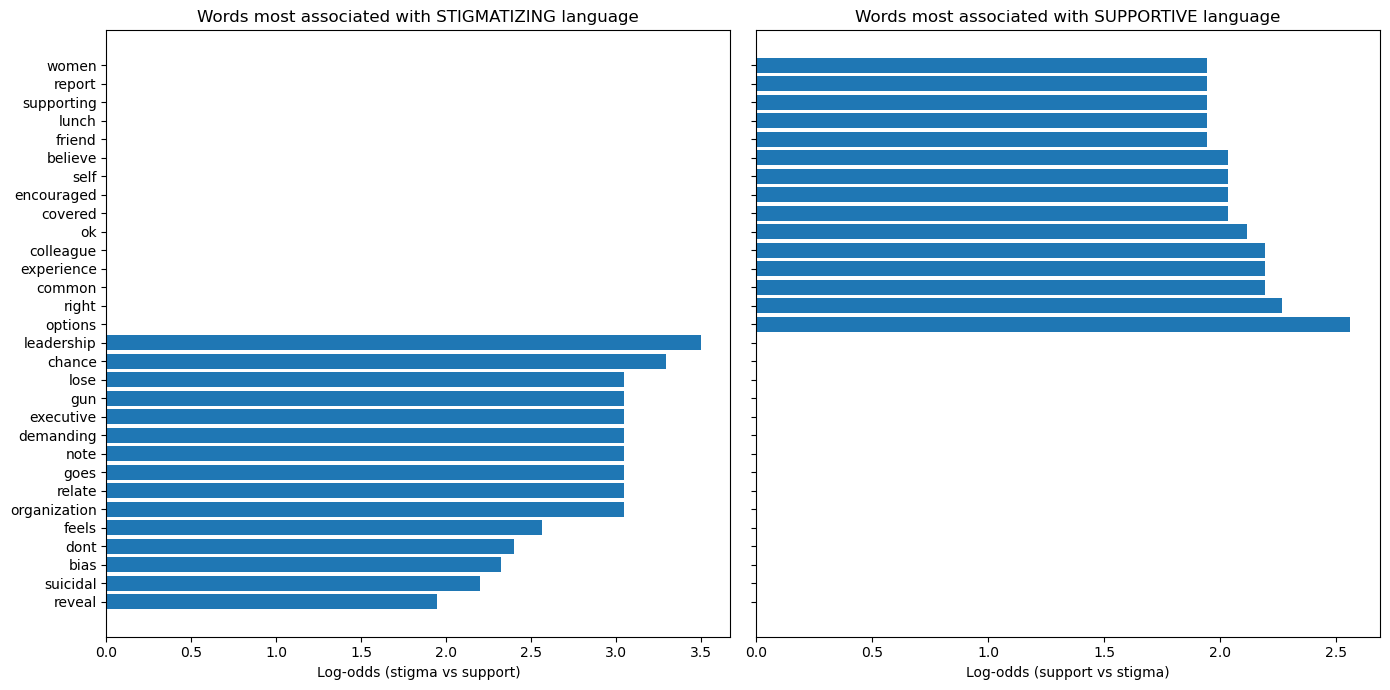

In [149]:
import matplotlib.pyplot as plt

K = 15  # Number of words

# Stigmatizing: words with biggest log_odds
stig_plot = top_stigma.nlargest(K, "log_odds").copy()
stig_plot = stig_plot.sort_values("log_odds")  

# Supportive: words with smaller log_odds
supp_plot = top_support.nsmallest(K, "log_odds").copy()
supp_plot = supp_plot.sort_values("log_odds")

fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True)

# Left: stigmatizing
axes[0].barh(stig_plot["word"], stig_plot["log_odds"])
axes[0].set_title("Words most associated with STIGMATIZING language")
axes[0].set_xlabel("Log-odds (stigma vs support)")

# Right: supportive (negative log_odds → switch sign)
axes[1].barh(supp_plot["word"], -supp_plot["log_odds"])
axes[1].set_title("Words most associated with SUPPORTIVE language")
axes[1].set_xlabel("Log-odds (support vs stigma)")

plt.tight_layout()
plt.show()

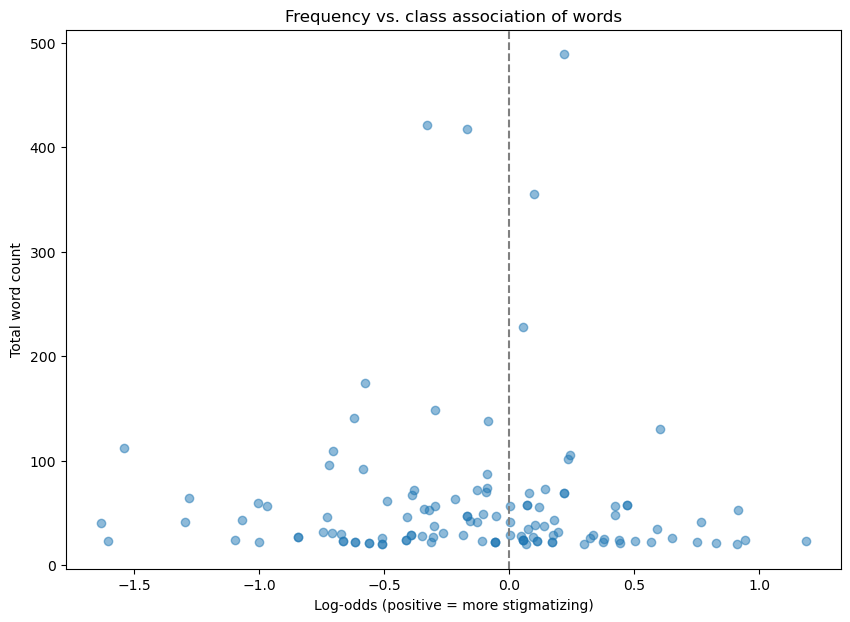

In [150]:
# Add total frequency
df_logodds["total_count"] = df_logodds["count_stigma"] + df_logodds["count_support"]

# Filtreeri rare instances (<20)
min_total = 20
plot_df = df_logodds[df_logodds["total_count"] >= min_total].copy()

plt.figure(figsize=(10, 7))
plt.scatter(
    plot_df["log_odds"],
    plot_df["total_count"],
    alpha=0.5,
)

plt.axvline(0, color="grey", linestyle="--")
plt.xlabel("Log-odds (positive = more stigmatizing)")
plt.ylabel("Total word count")
plt.title("Frequency vs. class association of words")
plt.show()

## Inference

### 1) Load the full dataset

In [119]:
df_full = pd.read_csv("../data/processed/full_text_dataset.csv")

### Use GPU (MPS on Mac) of available

In [124]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

model.to(device)

Using device: mps


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

## Create Inference Dataset class

When running inference on the full dataset, we do not have labels –  
we only need tokenized text to feed into the model.  
The class below mirrors the training dataset but removes the label component.

In [125]:
class InferenceDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
        }

## Prepare dataloader

To run inference efficiently, we batch the inputs using a PyTorch `DataLoader`.

In [126]:
from torch.utils.data import DataLoader, Dataset

In [127]:
texts = df_full["text"].astype(str).tolist()
dataset = InferenceDataset(texts, tokenizer)
loader = DataLoader(dataset, batch_size=32)

## Run inference

We now pass the full dataset through the fine-tuned RoBERTa model in batches.  
Gradient tracking is disabled to speed up inference and reduce memory usage.

In [129]:
preds = []

with torch.no_grad():
    for batch in loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        batch_preds = logits.argmax(dim=1).cpu().tolist()
        preds.extend(batch_preds)

df_full["stigma_pred"] = preds


### Save results


In [141]:
df_full.to_csv("../data/processed/full_with_predictions.csv", index=False)

# Preview the saved dataframe
df_full.head()

,year,text,label,stigma_pred
0,2014,"I'm not on my company's health insurance, whic...",NaN,0
1,2014,"I have chronic, low-level neurological issues ...",NaN,1
2,2014,"My company does provide healthcare, but not to...",NaN,0
3,2014,Relatively new job. Ask again later,NaN,1
4,2014,Sometimes I think about using drugs for my me...,NaN,1


### Trend analysis by year

We now examine how the predicted attitudes toward mental health evolve over time.  
Because the model outputs **1 = supportive** and **0 = stigmatizing**, the yearly mean of `stigma_pred`
directly represents the share of **supportive** responses.

In [131]:
trend = (
    df_full.groupby("year")["stigma_pred"]
    .mean()  # mean = % supportive (label 1)
    .reset_index()
    .rename(columns={"stigma_pred": "share_supportive"})
)

trend["share_stigmatizing"] = 1 - trend["share_supportive"]

print("\nTrend over years:")
trend


Trend over years:


,year,share_supportive,share_stigmatizing
0,2014,0.944785,0.055215
1,2016,0.749477,0.250523
2,2017,0.832642,0.167358
3,2018,0.870000,0.130000
4,2019,0.838806,0.161194
5,2020,0.660920,0.339080
6,2021,0.689655,0.310345
7,2022,0.641026,0.358974
8,2023,0.833333,0.166667


### Plotting Yearly Trends in Mental-Health Attitudes

To visualize how supportive vs. stigmatizing attitudes have changed over time,  
we plot the yearly proportions computed in the previous step.

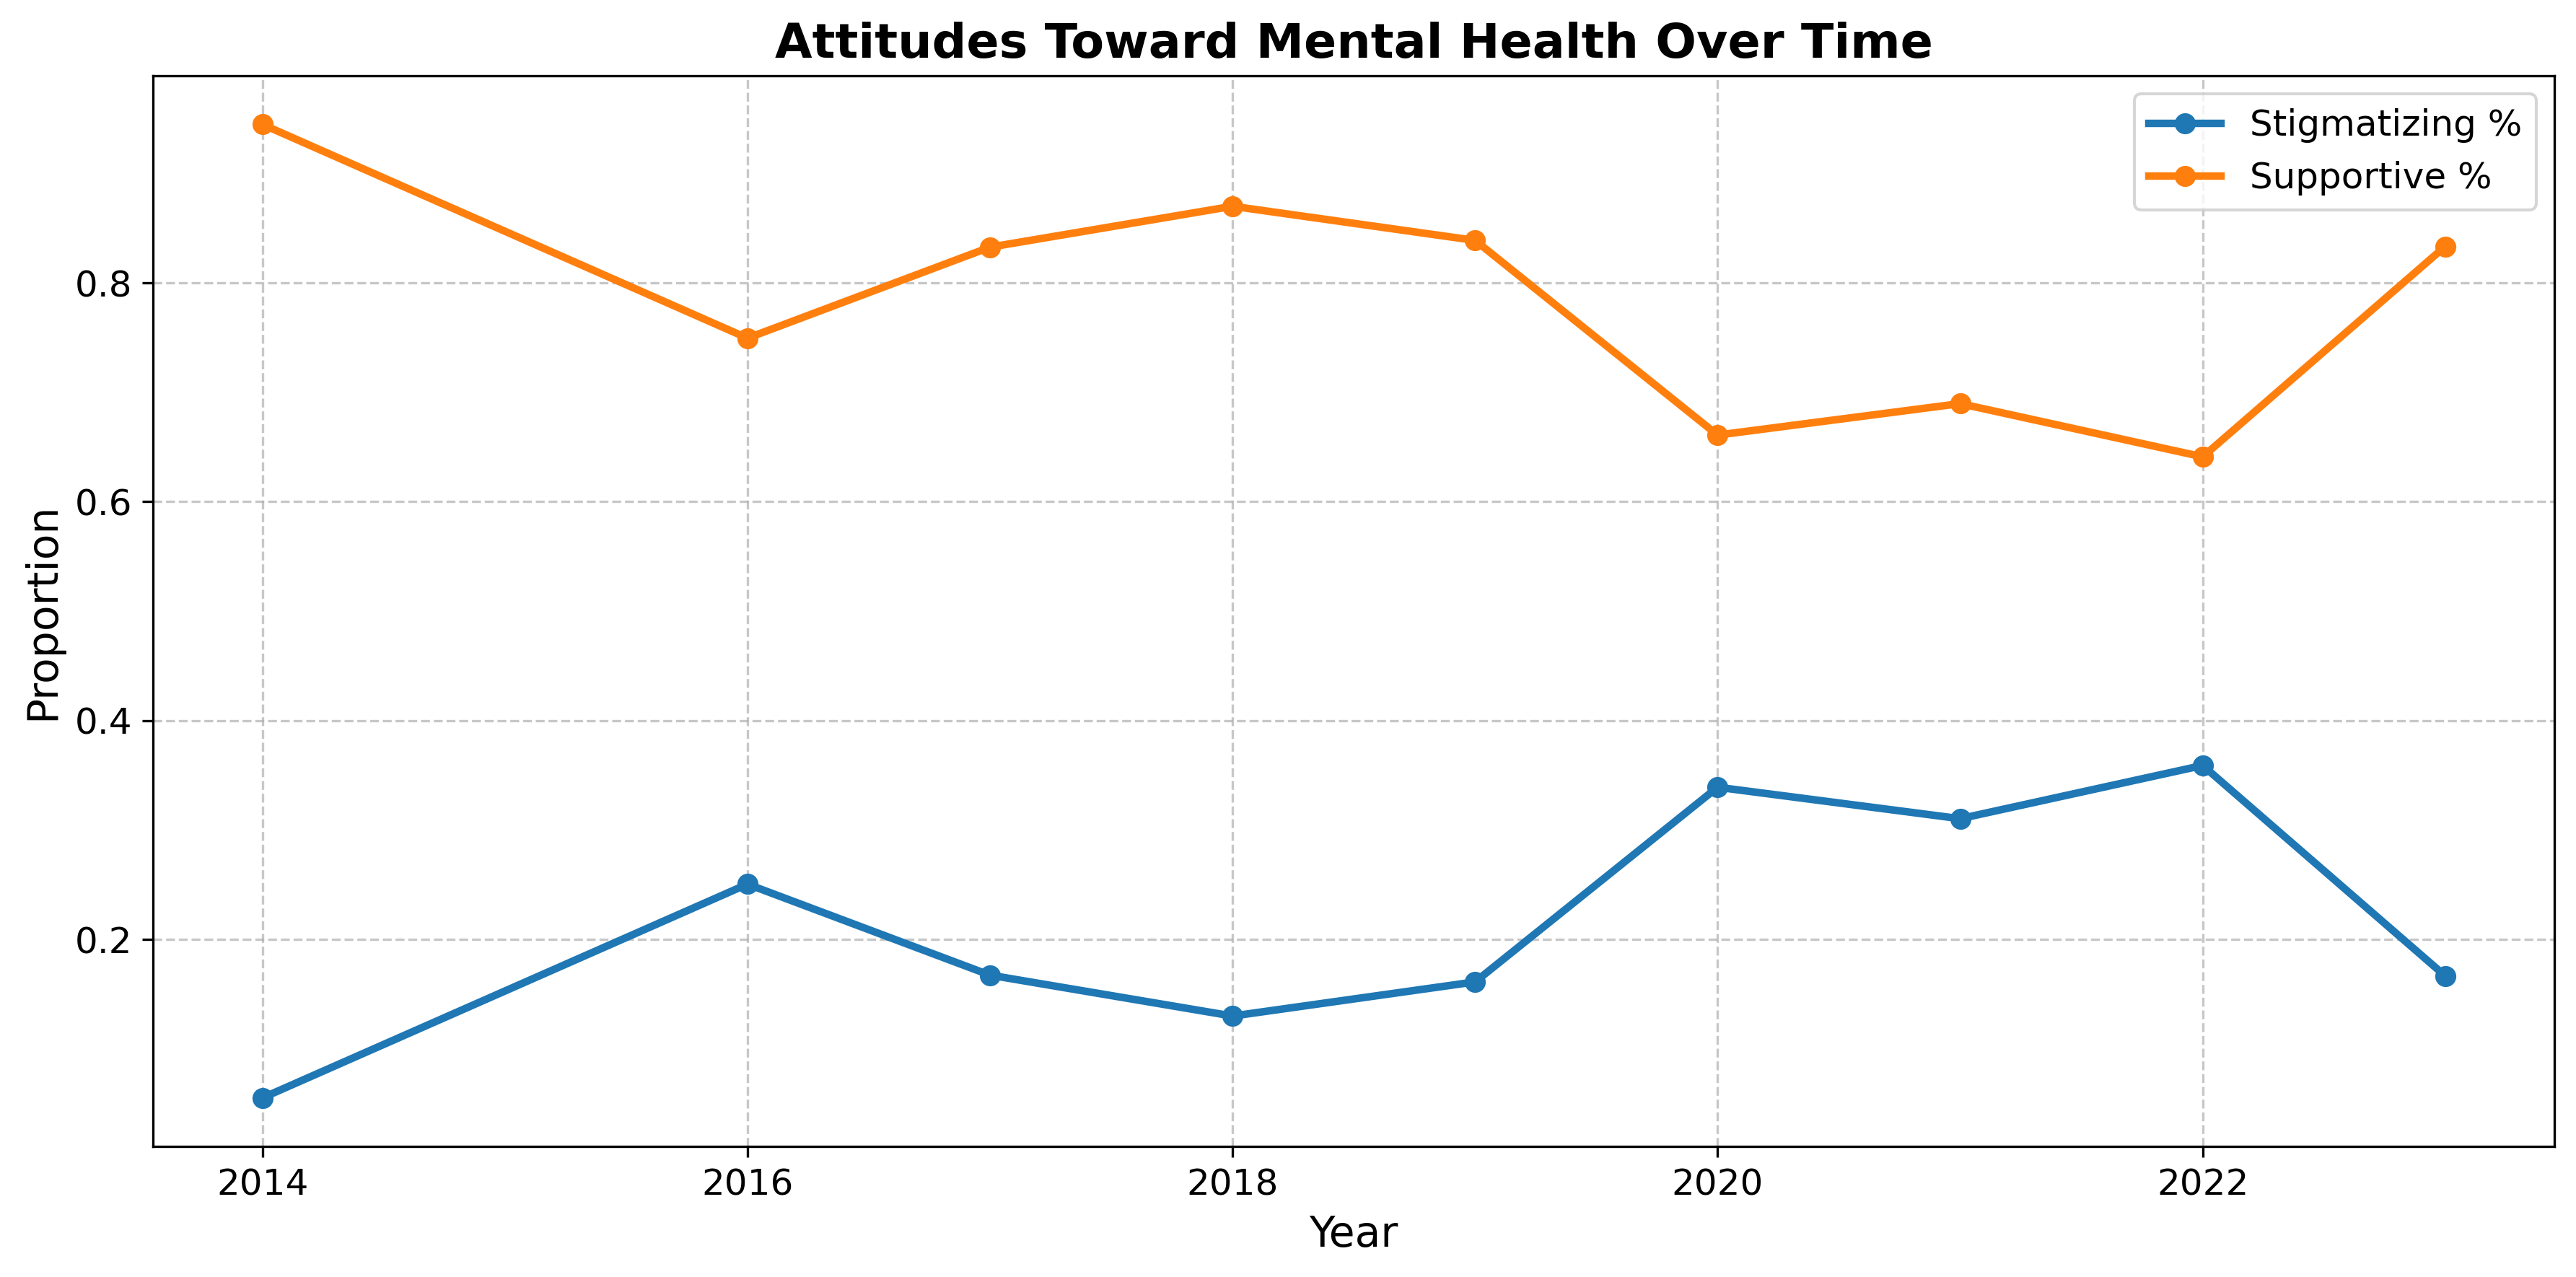

In [153]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6), dpi=300)

# Stigmatizing line
plt.plot(
    trend["year"],
    trend["share_stigmatizing"],
    marker="o",
    linewidth=2.5,
    label="Stigmatizing %",
)

# Supportive line
plt.plot(
    trend["year"],
    trend["share_supportive"],
    marker="o",
    linewidth=2.5,
    label="Supportive %",
)

# Labels
plt.title("Attitudes Toward Mental Health Over Time", fontsize=16, fontweight="bold")
plt.xlabel("Year", fontsize=14)
plt.ylabel("Proportion", fontsize=14)

# Tick adjustments
plt.tick_params(axis="both", which="major", labelsize=12)

# Grid
plt.grid(True, linestyle="--", alpha=0.7)

# Legend
plt.legend(fontsize=12)

# Tight layout
plt.tight_layout()

# Salvesta pildid (tee vajadusel kaust 'figures')
plt.savefig("../figures/attitudes_trend.pdf", format="pdf", bbox_inches="tight")

plt.show()

## Interpretation of Mental-Health Attitude Trends (2014–2023)

The graph displays the proportion of *stigmatizing* versus *supportive* statements about mental health in the tech industry from 2014 to 2023.

### 1. Supportive attitudes dominate across all years
In every year, supportive statements form the clear majority, typically ranging between **65% and 95%**.  
This indicates that discussions around mental health in tech are generally positive, empathetic, and open.  
Even in years where support dips, it remains substantially higher than stigmatizing attitudes.

### 2. Stigmatizing attitudes remain a minority but fluctuate
Stigmatizing statements remain mostly below **20%**, with notable increases in:

- **2016 (~25%)**
- **2020–2022 (~30–36%)**

These temporary increases may reflect external pressures such as organizational stress, workplace culture issues, or pandemic-related tensions.  
However, at no point do stigmatizing attitudes surpass supportive ones.

### 3. Strong recovery toward supportive language in 2023
In 2023, supportive attitudes rise back to approximately **84%**, while stigmatizing language drops to around **17%**.  
This suggests improvement in workplace culture, increased mental-health awareness, or the introduction of better support programs.

### Summary
- Supportive attitudes consistently dominate the discourse throughout the decade.
- Stigmatizing attitudes appear only in small proportions, despite temporary spikes.
- The overall long-term trajectory points toward **greater openness and reduced stigma** in discussions about mental health within the tech industry.